In [77]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import operator
from braket.aws import AwsDevice
from braket.devices import LocalSimulator
from qbraid import device_wrapper
from qbraid.visualization import plot_histogram

from braket.circuits.noise_model import (
    GateCriteria,
    NoiseModel,
    ObservableCriteria,
)
from braket.circuits import Circuit, Observable, Gate
from braket.circuits.noises import (
    BitFlip,
    Depolarizing,
    TwoQubitDepolarizing,
)
from braket.devices import LocalSimulator
import numpy as np
import math

T  : |0|1|2|
            
q0 : -H-C---
        |   
q1 : ---X-C-
          | 
q2 : -----X-

T  : |0|1|2|
(10, 20.635582429907494)
[10, 9, 1]
T  : |      0       |      1      |      2      |
                                                 
q0 : -H-DEPO(0.0022)-C-DEPO(0.073)---------------
                     | |                         
q1 : ----------------X-DEPO(0.073)-C-DEPO(0.066)-
                                   | |           
q2 : ------------------------------X-DEPO(0.066)-

T  : |      0       |      1      |      2      |
T   : |      0      |      1      |      2      |     3      |     4     |
                                                                          
q1  : -StartVerbatim-----------------------------X-DEPO(0.07)-EndVerbatim-
       |                                         | |          |           
q9  : -|---------------------------X-DEPO(0.063)-C-DEPO(0.07)-|-----------
       |                           | |                        |           
q10 : -*

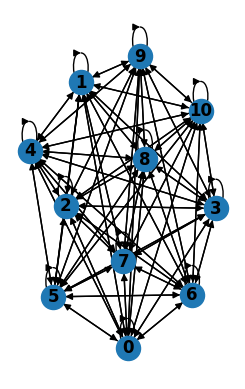

In [112]:
#Global circuit model
def createCircuit(qTemp):
    try:
        return Circuit().h(qTemp[0]).cnot(qTemp[0], qTemp[1]).cnot(qTemp[1],qTemp[2])
    except:
        print(f'qTemp is {qTemp}')
#Preliminary mapping
## qubit array with hypothetical 11 qubit hardware system
vq = [0,1,2,3,4,5,6,7,8,9,10,11]
c = createCircuit(vq)
qNum = c.qubit_count


#Global devices
device = LocalSimulator('braket_dm')
sim = LocalSimulator()


##noise model given to us by readme file
def noise_model():
    rng = np.random.default_rng()
    m = NoiseModel()
    
    two_q_depo_mu = 1 - 0.9311
    two_q_depo_sigma = 0.005
    bf_mu = 1 - 0.99752
    bf_sigma = 0.0015
    one_q_depo_mu = 1 - 0.9981
    one_q_depo_sigma = 0.00017
    for qi in range(11):
        z_bf_prob = bf_mu + bf_sigma * rng.standard_normal()
        z_bf_prob = 0.0 if z_bf_prob < 0.0 else z_bf_prob
        
        bf_prob = bf_mu + bf_sigma * rng.standard_normal()
        bf_prob = 0.0 if bf_prob < 0.0 else bf_prob
        
        one_q_depo_prob = one_q_depo_mu + one_q_depo_sigma * rng.standard_normal()
        one_q_depo_prob = 0.0 if one_q_depo_prob < 0.0 else one_q_depo_prob
        
        m.add_noise(BitFlip(z_bf_prob), ObservableCriteria(observables=Observable.Z, qubits=qi))
        #m.add_noise(BitFlip(bf_prob), ObservableCriteria(qubits=qi))
        
        m.add_noise(Depolarizing(one_q_depo_prob), GateCriteria(qubits=qi))
        for qj in range(11):
            if not qj == qi:
                two_q_depo_prob = two_q_depo_mu + two_q_depo_sigma * rng.standard_normal()
                two_q_depo_prob = 0.0 if two_q_depo_prob < 0.0 else two_q_depo_prob
                
                m.add_noise(TwoQubitDepolarizing(two_q_depo_prob), GateCriteria(gates=[Gate.CNot, Gate.Swap, Gate.CPhaseShift], qubits=[qi, qj]))
    return m

# examine the noiseless circuit 
print(c)

## initializes and sorts a list of usage counts for each quBit
## this is used to determine which qubits get swapped with the better(higher fidelity) qubits
gate_count = c.instructions[1].target

qbitCounts = [0] * qNum

for gate in c.instructions:
    for i in gate.target:
        strI = str(i)
        intI = (int(strI[6:len(strI)-1]))

        qbitCounts[intI]+=1

qbitCounts.sort(reverse = True) #Problem – sorting it destroyed the structure

#Getting the edge list (list of tuples, with (qubit, qubit, fidelity)

edge_list = []
for instruction in noise_model().instructions:
    temp = [None,None,None]
    test = instruction.to_dict()
    #print(test.keys())
    #print(test['noise']['__class__'])
    #print(test['criteria'])
    if test['noise']['__class__'] == 'TwoQubitDepolarizing':
        if test['criteria']['gates'] != None:
            temp[0]=test['criteria']['qubits'][0][0]
            temp[1]=test['criteria']['qubits'][0][1]
            temp[2]=1.-test['noise']['probability']
    if temp[0]!=None and temp[1]!=None and temp[2]!=None:
        edge_list.append(tuple(temp))

#Network generation, along with node edges sorted
import networkx as nx

graph = nx.MultiDiGraph()
graph.add_weighted_edges_from(edge_list)
for i in graph.nodes():
    graph.add_edge(i,i,0)

node_degrees=dict()

for i in graph.nodes():
    node_degrees[i] = graph.degree(i,weight='weight')

node_degrees=sorted(node_degrees.items(),key=operator.itemgetter(1), reverse=True)


##graph visualization
subax1 = plt.subplot(121)
nx.draw(graph, with_labels=True, font_weight='bold')



##Getting qubit frequency
two_qubit_list = {}
instruction_list = ['CNot', 'Swap', 'CPhaseShift']
for i in range(len(c.instructions)):
    strI = str(c.instructions[i].operator)
    temp = strI[0:4]
    #print(temp)
    if temp in instruction_list:
        sets = str(c.instructions[i].target)

        try:
            two_qubit_list[(sets[16],sets[-4])] +=1
        except:
            two_qubit_list[(sets[16],sets[-4])] = 1
            
two_qubit_list = sorted(two_qubit_list.items(), key=operator.itemgetter(1), reverse=True)

rq = [-1] * qNum

##graph visualization
subax1 = plt.subplot(121)
#nx.draw(graph, with_labels=True, font_weight='bold')


##Optimal paths from node

max_n = max(node_degrees)
print(max_n)

def bft(qubit_start, quBitCount):
    visited = []
    visited.append(qubit_start[0])
    while len(visited) < quBitCount:
        max_edge = (0, 0, 0)
        for node in visited:
            for edge in edge_list:
                
                if(edge[0] in visited and edge[1] not in visited and edge[2] > max_edge[2]):
                    max_edge = edge
        visited.append(max_edge[1])
       
    return visited
rq = bft(max_n,qNum)

print(rq)

# apply the noise model to the circuit 
nm = noise_model()
c = nm.apply(c)

# examine the noisy circuit 
print(c)

#Running the experiment (For later use)

# run the simulation!
result = device.run(c, shots=1000).result()

# now improve the mapping based on the results!

verbatimC = createCircuit(rq)
verbatimC = Circuit().add_verbatim_box(verbatimC)

nm1 = noise_model()
verbatimC = nm1.apply(verbatimC)
print(verbatimC)

improvedResult = device.run(c, shots=1000).result()

iq = createCircuit([i for i in range(0,qNum)])
idealResult = sim.run(iq,shots=1000).result()

#print(result.measurement_counts())
#print(improvedResult.measurement_counts())
#print(f'improvedResult is {improvedResult.measurement_counts}')




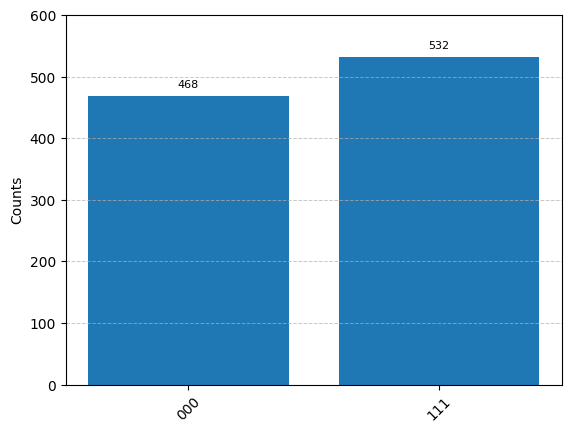

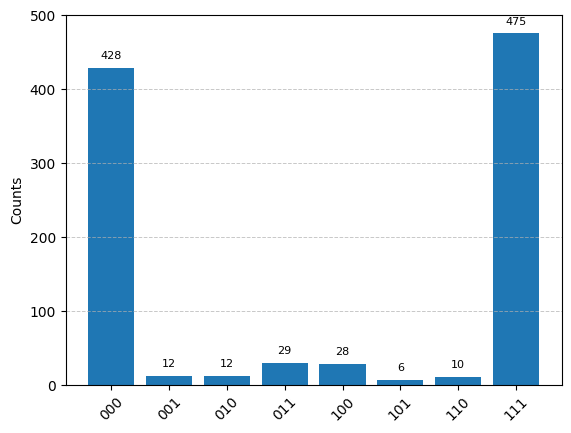

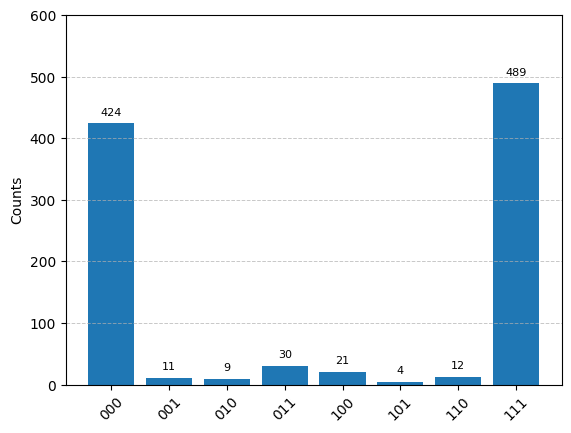

In [114]:
plot_histogram(idealResult.measurement_counts)
plot_histogram(result.measurement_counts)
plot_histogram(improvedResult.measurement_counts)

In [115]:
regularCounter = result.measurement_counts
improvedCounter = plot_histogram(improvedResult.measurement_counts)

AttributeError: 'GateModelQuantumTaskResult' object has no attribute 'measurement'